In [89]:
import pandas as pd 
import numpy as np 
from transformers import BertTokenizer, TFBertForSequenceClassification
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import tensorflow as tf
device = torch.device("cuda")
df = pd.read_csv("Merged_Emotions.csv")


In [24]:
# Create a new column Match_cat
df['Match_cat'] = df['Match'].map({'FIFA World Cup 2022': 1, 'UEFA European Championship 2024': 2, 
'Premier League 2024': 3, 'Champions League 2024': 4})
df.tail()

# Split csv
from sklearn.model_selection import train_test_split 
  
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['Match_cat'],  
                                                                    random_state = 2024,  
                                                                    test_size = 0.3,  
                                                                    stratify = df['Match_cat']) 
  
  
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,  
                                                                random_state = 2024,  
                                                                test_size = 0.5,  
                                                                stratify = temp_labels)

train_text

71                              Sigh Martinez... but lol.
1002    u/alexinup and u/PSGAcademy competing in a WC ...
2023    If you beat Italy, Croatia, Germany, France an...
2069    Kane is non existent, walker too sloppy, Belli...
4100    ngl Bissouma getting a yellow  seconds into th...
                              ...                        
582                                    Mbappe with Adidas
1520                    So fucking happy that france lost
5810    Not to bat for Madrid here, but that's rich co...
3659    Disappointed, but given how badly we played ea...
2238            Should've started with Palmer and Watkins
Name: text, Length: 4603, dtype: object

In [25]:
tokenizer = BertTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-original")
model = TFBertForSequenceClassification.from_pretrained("monologg/bert-base-cased-goemotions-original", from_pt = True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


# Tokenize Data

(array([4.329e+03, 2.050e+02, 4.900e+01, 1.500e+01, 3.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  1. ,  49.3,  97.6, 145.9, 194.2, 242.5, 290.8, 339.1, 387.4,
        435.7, 484. ]),
 <BarContainer object of 10 artists>)

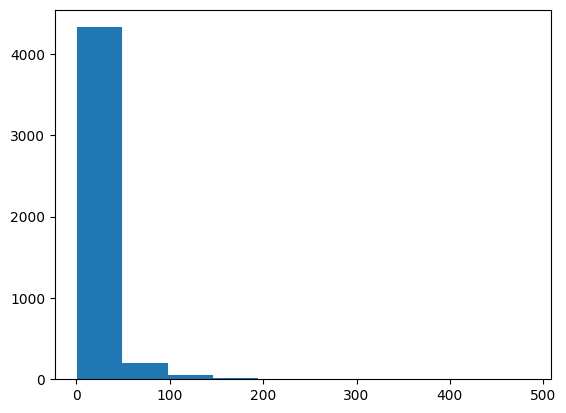

In [49]:
train_lens = [str(i).split() for i in train_text]
train_lens = [len(i) for i in train_lens]
plt.hist(train_lens)

In [20]:
# Most comments have around 25 words so padding length = 25
pad_len = 25

In [55]:
# Ensure that inputs are lists of strings
train_text = [str(item) if item is not None else '' for item in train_text]
val_text = [str(item) if item is not None else '' for item in val_text]
test_text = [str(item) if item is not None else '' for item in test_text]

# Tokenize and encode sequences for training, validation, and testing
tokens_train = tokenizer.batch_encode_plus(
    train_text, 
    max_length=pad_len, 
    padding=True,  # Automatically pad to max_length
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text, 
    max_length=pad_len, 
    padding=True,  # Automatically pad to max_length
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text, 
    max_length=pad_len, 
    padding=True,  # Automatically pad to max_length
    truncation=True
)

# Convert tokenized outputs to tensors
train_seq = torch.tensor(tokens_train['input_ids']) 
train_mask = torch.tensor(tokens_train['attention_mask']) 
train_y = torch.tensor(train_labels.tolist())  # Ensure train_labels is a list or tensor

val_seq = torch.tensor(tokens_val['input_ids']) 
val_mask = torch.tensor(tokens_val['attention_mask']) 
val_y = torch.tensor(val_labels.tolist())  # Ensure val_labels is a list or tensor

test_seq = torch.tensor(tokens_test['input_ids']) 
test_mask = torch.tensor(tokens_test['attention_mask']) 
test_y = torch.tensor(test_labels.tolist())  # Ensure test_labels is a list or tensor


In [59]:
#freeze the pretrained layers 
for param in model.trainable_variables: 
    param.requires_grad = False
  
#defining new layers 
class BERT_architecture(nn.Module): 
  
    def __init__(self, bert): 
        
      super(BERT_architecture, self).__init__() 
  
      self.bert = bert  
        
      # dropout layer 
      self.dropout = nn.Dropout(0.2) 
        
      # relu activation function 
      self.relu =  nn.ReLU() 
  
      # dense layer 1 
      self.fc1 = nn.Linear(768,512) 
        
      # dense layer 2 (Output layer) 
      self.fc2 = nn.Linear(512,2) 
  
      #softmax activation function 
      self.softmax = nn.LogSoftmax(dim=1) 
  
    #define the forward pass 
    def forward(self, sent_id, mask): 
  
      #pass the inputs to the model   
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False) 
        
      x = self.fc1(cls_hs) 
  
      x = self.relu(x) 
  
      x = self.dropout(x) 
  
      # output layer 
      x = self.fc2(x) 
        
      # apply softmax activation 
      x = self.softmax(x) 
  
      return x

In [71]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [72]:
# pass the pre-trained BERT to our define architecture
bert_model = BERT_architecture(model)

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(bert_model.parameters(),lr = 1e-5)  # learning rate

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [73]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels 
                                     )
print("class weights are {} for {}".format(class_weights,np.unique(train_labels)))

class weights are [0.82196429 0.83690909 2.14692164 0.89067337] for [1 2 3 4]


In [84]:
# function to train the model
def train():
  
  bert_model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [85]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  bert_model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [79]:
epochs = 6

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print('\nTraining Loss: {}'.format(train_loss))
    print('Validation Loss: {}'.format(valid_loss))


 Epoch 1 / 6


AssertionError: Torch not compiled with CUDA enabled

In [92]:
# get predictions for test data 
with torch.no_grad(): 
  preds = model(test_seq.to(device), test_mask.to(device)) 
  preds = preds.detach().cpu().numpy() 
    
from sklearn.metrics import classification_report 
pred = np.argmax(preds, axis = 1) 
print(classification_report(test_y, pred))

AssertionError: Torch not compiled with CUDA enabled